<a href="https://colab.research.google.com/github/marcelolandivar/Python_Projects/blob/master/Food_Report-Pyspark%26SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Market Report 
**Report from a SQL DB using Spark** \
###By: Marcelo Landivar
---

>**Email:** <MarceloLandivar24@gmail.com>\
> **RESOURCES:**  PySpark & SQL


The report is divided in two sections. One part is the technical part about memory usage of the different tables involved in this report and the second part is the Summary of the performance of the Food Market

In [ ]:
import pyspark
import operator
import time
from pyspark import SparkConf, SparkContext
import time
from pyspark.sql import SparkSession, SQLContext

In [ ]:
conf = SparkConf().setMaster('local').setAppName('AssignmentI')
con = SparkContext(conf=conf)

In [ ]:
spark = SparkSession.builder.getOrCreate()

prod = pd.read_excel("FoodMarket.xlsx",sheet_name="Products")
cust = pd.read_excel("FoodMarket.xlsx",sheet_name="Customers")
purc = pd.read_excel("FoodMarket.xlsx",sheet_name="Purchases")
sell = pd.read_excel("FoodMarket.xlsx",sheet_name="Sellers")


products= spark.createDataFrame(prod)
customers = spark.createDataFrame(cust)
purchases = spark.createDataFrame(purc)
sellers = spark.createDataFrame(sell)

In [ ]:
products.registerTempTable('products_table')
customers.registerTempTable('customers_table')
purchases.registerTempTable('purchases_table')
sellers.registerTempTable('sellers_table')

##  Memory Usage Report

### Memory Usage for the Merged DataFrame

The following is the DataFrame of all the individual tables of the Food Market: 

-Products table

-Customers table

-Purchases table

-Sellers table

In [ ]:
all_df = spark.sql("""select s.Code, s.Name, Lat, Long, Buyer, Product, Quantity, Seller, p.Name as Product_name,	Price,
                    c.Name, Surname from sellers_table s right join purchases_table pu 
                    on s.Code = pu.Seller
                    left join products_table p on pu.Product = p.Code
                    left join customers_table c on c.Code = pu.Buyer""")


In [ ]:
all_df_2 = all_df.toPandas()

In [ ]:
all_df_2.set_index('Code')

,Name,Lat,Long,Buyer,Product,Quantity,Seller,Product_name,Price,Name,Surname
Code,,,,,,,,,,,
38,From The Farmer,49.1,-79.5,26,54,17,38,Rolled foods,9.08,Andrew,Jackson
52,Complete Collection,-49.9,9.0,26,17,8,52,Cocktails,14.46,Andrew,Jackson
40,Savory Sock,26.9,99.1,26,37,1,40,Italian dishes,0.97,Andrew,Jackson
51,Farmer’S Bounty,3.7,-47.8,26,36,20,51,Indonesian dishes,13.55,Andrew,Jackson
33,Great Grains,-14.2,20.9,26,46,2,33,Pastries,4.22,Andrew,Jackson
...,...,...,...,...,...,...,...,...,...,...,...
38,From The Farmer,49.1,-79.5,24,50,7,38,Potato dishes,17.72,Paul,Hall
15,Goodness Grocery,-19.6,51.9,24,55,8,15,Sauces,3.97,Paul,Hall
51,Farmer’S Bounty,3.7,-47.8,24,36,2,51,Indonesian dishes,13.55,Paul,Hall


Number of Rows and Columns for the merged DataFrame:

In [ ]:
all_df_2.count(), len(all_df_2.columns)

(Code            1500
 Name            1500
 Lat             1500
 Long            1500
 Buyer           1500
 Product         1500
 Quantity        1500
 Seller          1500
 Product_name    1500
 Price           1500
 Name            1500
 Surname         1500
 dtype: int64, 12)

Memory Usage of the whole dataframe by column:

In [ ]:
all_df.memory_usage()

Index             128
Code            12000
Name            12000
Lat             12000
Long            12000
Buyer           12000
Product         12000
Quantity        12000
Seller          12000
Product_name    12000
Price           12000
Name            12000
Surname         12000
dtype: int64

Memory Usage of individual dataframes for each of the tables:

In [ ]:
print('The whole table combined memory usage: ',all_df.toPandas().memory_usage().sum())
print('The products table combined memory usage: ',products.toPandas().memory_usage().sum())
print('The purchases table combined memory usage: ',purchases.toPandas().memory_usage().sum())
print('The customers table combined memory usage: ',customers.toPandas().memory_usage().sum())
print('The sellers table combined memory usage: ',sellers.toPandas().memory_usage().sum())

The whole table combined memory usage:  144128
The products table combined memory usage:  1808
The purchases table combined memory usage:  60128
The customers table combined memory usage:  5096
The sellers table combined memory usage:  1984


## Business Report

In [ ]:
spark.sql("""Select round(sum(pu.Quantity)*sum(p.Price),2) as Revenues
            from purchases_table pu
            join sellers_table s on s.Code = pu.Seller
            join products_table p on p.Code=pu.Product
            join customers_table c on pu.Buyer = c.Code
            """).show()

+--------------+
|      Revenues|
+--------------+
|2.2944522888E8|
+--------------+



In [ ]:
Total_products_sold = spark.sql("Select sum(Quantity) as Total_sold_products from purchases_table")

### Total Products Sold

The total number of products sold is the following:

In [ ]:
tt = Total_products_sold.toPandas()

In [ ]:
tt_1 = tt.set_index([pd.Index(['-']), 'Total_sold_products'])

In [ ]:
tt_1

,
,Total_sold_products
-,16323


In [ ]:
product_people = spark.sql("""select concat(c.Name, ' ', c.Surname) as Customer_Name,
            sum(pu.Quantity) as Total_Products
            from purchases_table pu
            join sellers_table s on s.Code = pu.Seller
            join products_table p on p.Code=pu.Product
            join customers_table c on pu.Buyer = c.Code
            group by concat(c.Name, ' ', c.Surname)
            order by Total_Products desc
            limit 10
            """)

In [ ]:
revenues_people = spark.sql("""select concat(c.Name, ' ', c.Surname) as Customer_Name,
            round(sum(pu.Quantity)*sum(p.Price),2) as Revenues
            from purchases_table pu
            join sellers_table s on s.Code = pu.Seller
            join products_table p on p.Code=pu.Product
            join customers_table c on pu.Buyer = c.Code
            group by concat(c.Name, ' ', c.Surname)
            order by Revenues desc
            limit 10
            """)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

### Top ten clients by Quantity of Products

In [ ]:
pp = product_people.toPandas()

It is possible to observe that from the total number of products sold, which is 16323, 1434 are coming from the top 10 clients. In other words, 8.79% of the sells is from the top customers.

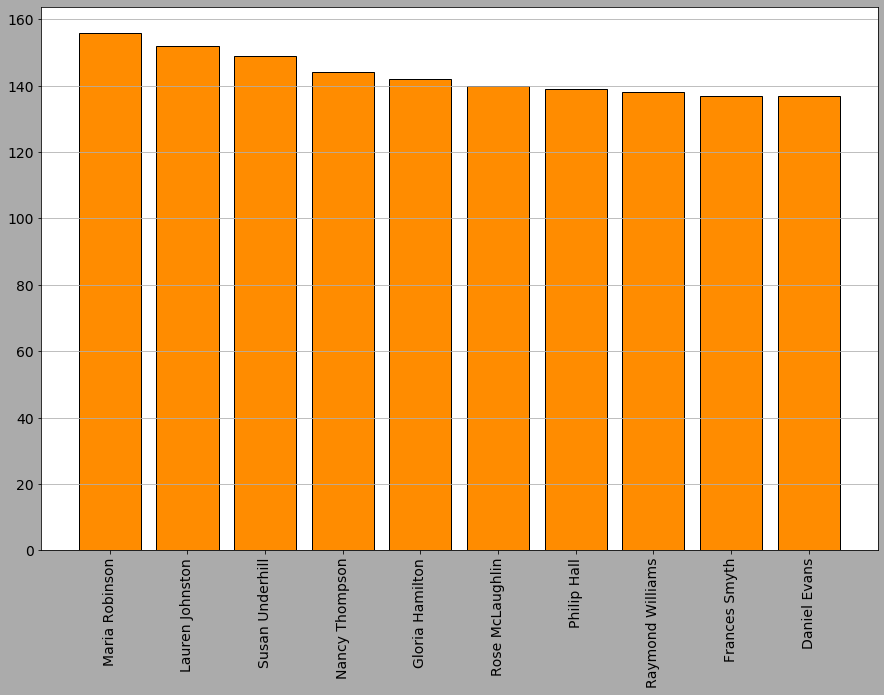

In [ ]:
plt.figure(figsize=(15,10), facecolor='#ababab')
plt.bar('Customer_Name', 'Total_Products', data=pp, color='darkorange', edgecolor='black')
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.grid(b=True, which='major', axis='y')
plt.show();
#plt.annotate('Highest', xy=(1,160), xytext =(-0.3,158), fontsize=15 )

### Top 10 clients by Revenue

In [ ]:
rp = revenues_people.toPandas()

The following are the Top 10 customers of the Food Market with the exact Revenues:

In [ ]:
rp.set_index('Customer_Name')

,Revenues
Customer_Name,
Gloria Hamilton,22178.98
Susan Underhill,21497.72
Maria Robinson,21354.84
Lauren Johnston,19267.52
Nancy Thompson,17776.80
Philip Hall,17448.67
Daniel Evans,17022.25
Grace Smyth,16706.47
Raymond Williams,16565.52


The total revenues are 229 millions units from which around 190 thousands come from the top customers that is the 0.08%. It is possible to observed in the follwing bar chart of the Top Clients.

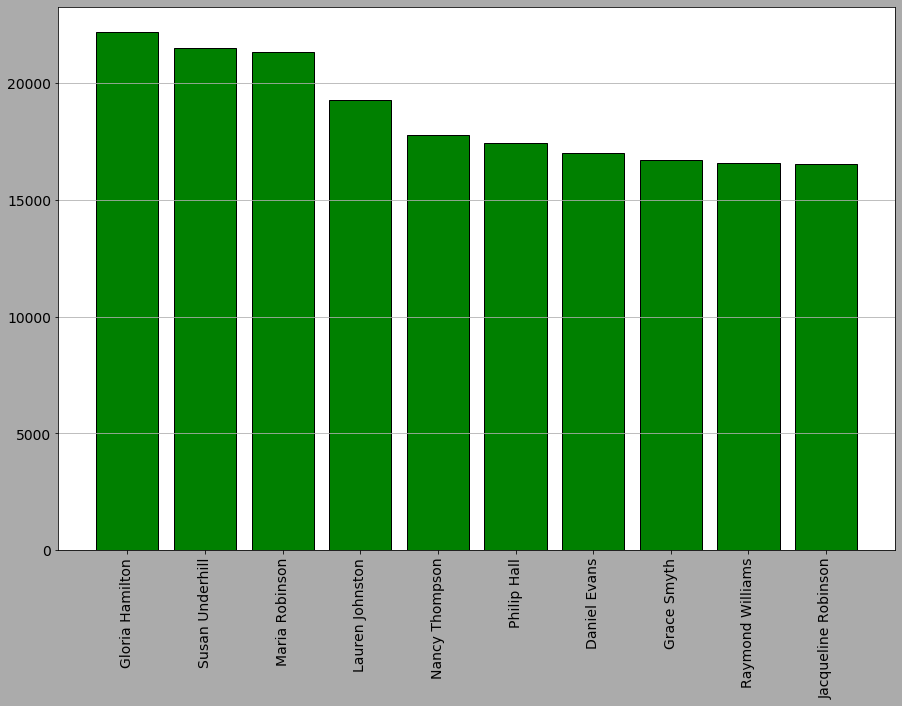

In [ ]:
plt.figure(figsize=(15,10), facecolor='#ababab')
plt.bar('Customer_Name', 'Revenues', data=rp, color='green', edgecolor='black')
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.grid(b=True, which='major', axis='y')
plt.show();
#plt.annotate('Highest', xy=(1,160), xytext =(-0.3,158), fontsize=15 )

In [ ]:
max_products = spark.sql("""select p.Name as Product_Name,
            sum(pu.Quantity) as Total_Products
            from purchases_table pu
            join sellers_table s on s.Code = pu.Seller
            join products_table p on p.Code=pu.Product
            join customers_table c on pu.Buyer = c.Code
            group by p.Name
            order by Total_Products desc
            limit 10
            """)

In [ ]:
mp = max_products.toPandas()

### Top 10 Products Sold

The top product sold are the following observed in the following bar chart:

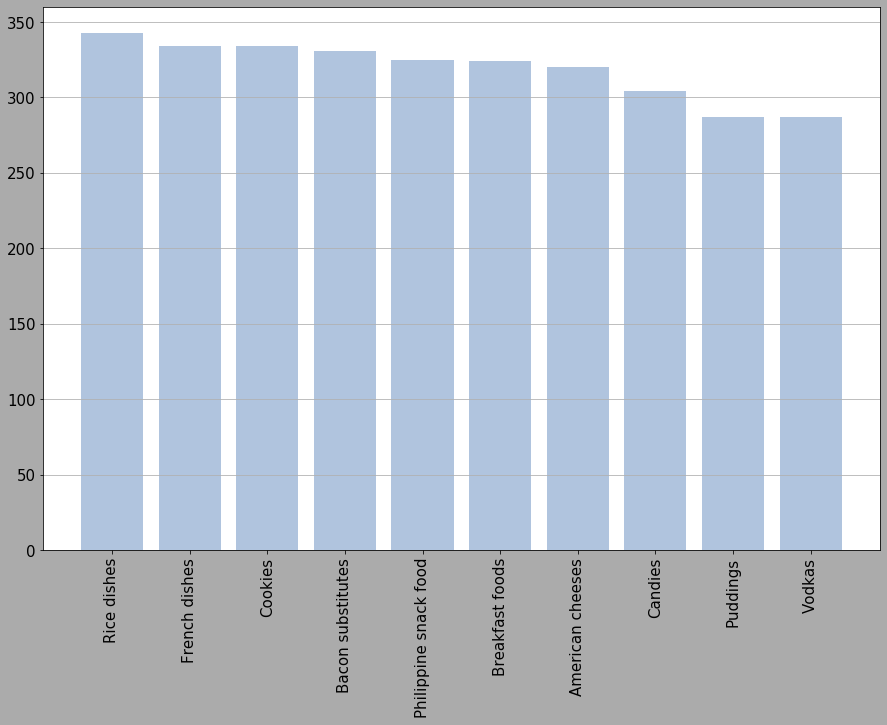

In [ ]:
plt.figure(figsize=(15,10), facecolor='#ababab')
plt.bar(x='Product_Name', height='Total_Products',data=mp, color='lightsteelblue')
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.grid(b=True, axis='y')
plt.show();

In [ ]:
top_sellers = spark.sql("""select
            s.Name as Sellers,
            sum(pu.Quantity),
            round(sum(pu.Quantity)*sum(p.Price),2) as Revenues
            from purchases_table pu
            join sellers_table s on s.Code = pu.Seller
            join products_table p on p.Code=pu.Product
            join customers_table c on pu.Buyer = c.Code
            group by Sellers
            order by Revenues desc
            limit 10
            """)

### Top 10 Sellers

The following are the Top 10 sellers of the Food Market with the exact Revenues:

In [ ]:
ts.set_index('Sellers')

,sum(Quantity),Revenues
Sellers,,
Stocked And Savory,428,165319.28
Growing Grocery,393,147547.92
Freedom Foods,414,143244.00
TheFarmory,369,139858.38
Grateful Grocer,390,137911.80
Freshest Fields,356,108900.40
Friendly Faces Foods,375,107126.25
Creative Carts,373,104674.99
Full Of Goodness,324,102290.04


In [ ]:
ts = top_sellers.toPandas()

The top seller is Stocked and Savroy with $ 165.319,28 in revenues. The top 10 sellers are showin the following bar chart. 

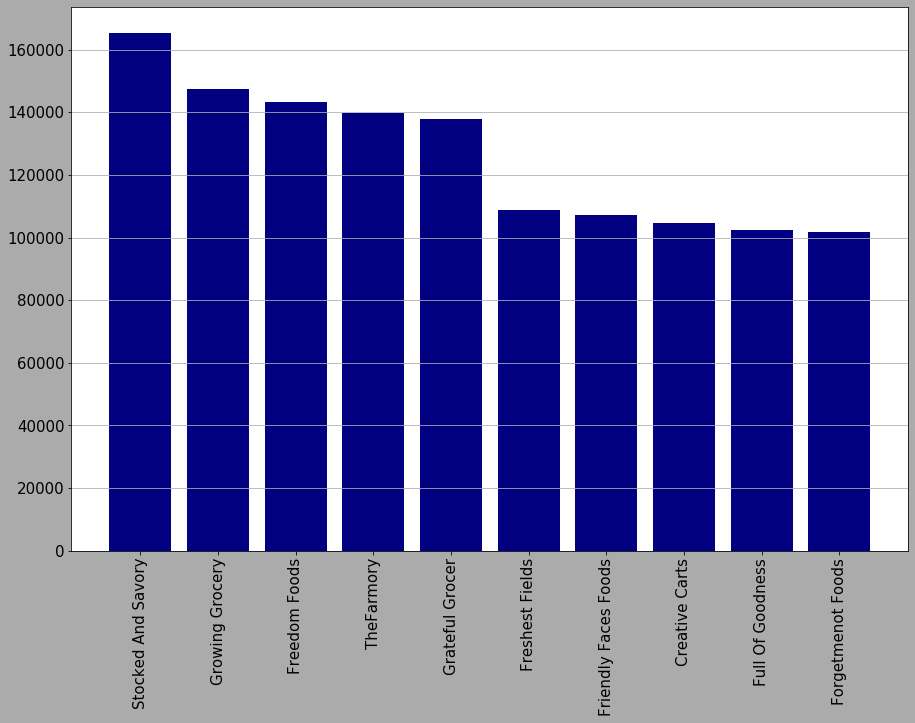

In [ ]:
plt.figure(figsize=(15,10), facecolor='#ababab')
plt.bar(x='Sellers', height='Revenues',data=ts, color='navy')
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.grid(b=True, axis='y')
plt.show();

In [ ]:
Customer_sells_products = spark.sql("""select concat(c.Name, ' ', c.Surname) as Customer_Name,
            sum(pu.Quantity) as Total_Products,
            round(sum(pu.Quantity)*sum(p.Price),2) as Total_sells
            from purchases_table pu
            join sellers_table s on s.Code = pu.Seller
            join products_table p on p.Code=pu.Product
            join customers_table c on pu.Buyer = c.Code
            group by concat(c.Name, ' ', c.Surname)
            order by Total_Sells desc
            """)

In [ ]:
csp = Customer_sells_products.toPandas()